In [1]:
# Libraries
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras. layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
import numpy as np

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from IPython import display
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# build function for the Keras' scikit-learn API
def create_keras_model():
    
    # Initialize the model
    model = Sequential()

    # Add convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    # Add a fully connected layer
    model.add(Dense(128, activation='relu'))

    # Add an output layer with a single node and sigmoid activation function
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [3]:
# create the classifier
classifier = KerasClassifier(create_keras_model)

C:\Users\karip\AppData\Local\Temp\ipykernel_82896\3876518441.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(create_keras_model)


In [4]:
# create the classifier
classifier2 = RandomForestClassifier()

In [5]:
# Specify the paths to the directories containing the images
non_COVID = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\non-COVID'
COVID = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\COVID'

In [6]:
# Initialize lists to store the images and labels
images = []
labels = []

# Set the batch size and epochs for training
batch_size = 16
epochs = 10

In [7]:
# Load the images and labels from the non-COVID and COVID directories
for image_dir, label in [(non_COVID, 0), (COVID, 1)]:
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img = Image.open(os.path.join(image_dir, filename))
        img = img.convert('L')
        img = img.resize((128, 128))        
        img = np.array(img)
        img = img / 255
        img = np.expand_dims(img, 2)
        images.append(img)
        labels.append(label)

In [8]:
# Convert the images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [9]:
print(len(images))
print(images.shape)
print(labels)

2381
(2381, 128, 128, 1)
[0 0 0 ... 1 1 1]


In [10]:
# Create X_train, X_val, X_test, Y_train, y_val, y_test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# Create the train, validation, and test datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [12]:
# Prints that help to better understand the dataset samples
print(f'Number of samples in each set (train, val, test): {len(X_train), len(X_val), len(X_test)}')
print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')
print("Number of positives:", y_train.sum() + y_val.sum() + y_test.sum())
print("Number of all samples:", len(X_train) + len(X_val) + len(X_test))
print("Number of all samples in the datasets:", len(train_ds) * 16 + len(val_ds) * 16 + len(test_ds) * 16)
print("Diff between all samples and dataset samples:", (len(train_ds) * 16 + len(val_ds) * 16 + len(test_ds) * 16) - (len(X_train) + len(X_val) + len(X_test)))

Number of samples in each set (train, val, test): (1523, 381, 477)
Number of positive samples in each set: (766, 203, 233)
Number of positives: 1202
Number of all samples: 2381
Number of all samples in the datasets: 2400
Diff between all samples and dataset samples: 19


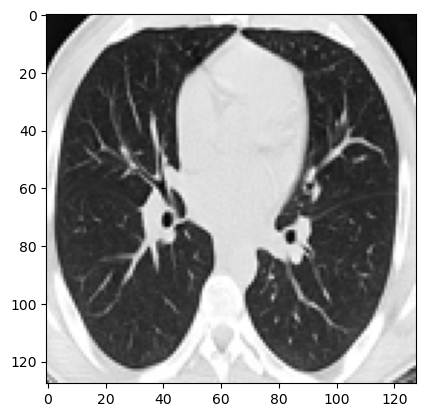

In [13]:
# pick a random image from the dataset
random_image = random.randint(0, len(images))

# display the image
plt.imshow(images[random_image], cmap='gray')
plt.show()

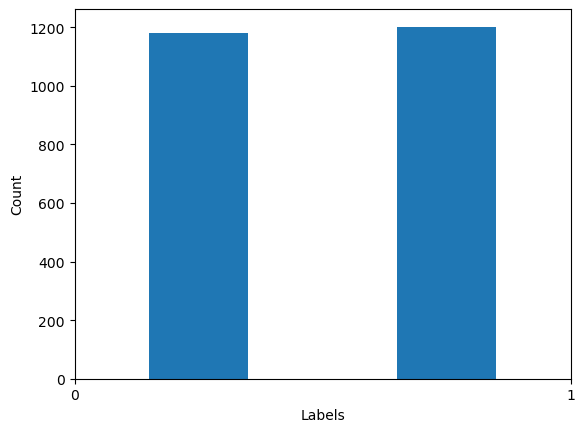

In [14]:
# Plot the distribution of labels
plt.hist(labels, bins=2, rwidth=0.4, range=(0, 1))
plt.xticks([0, 1])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

IndexError: index 25 is out of bounds for axis 0 with size 25

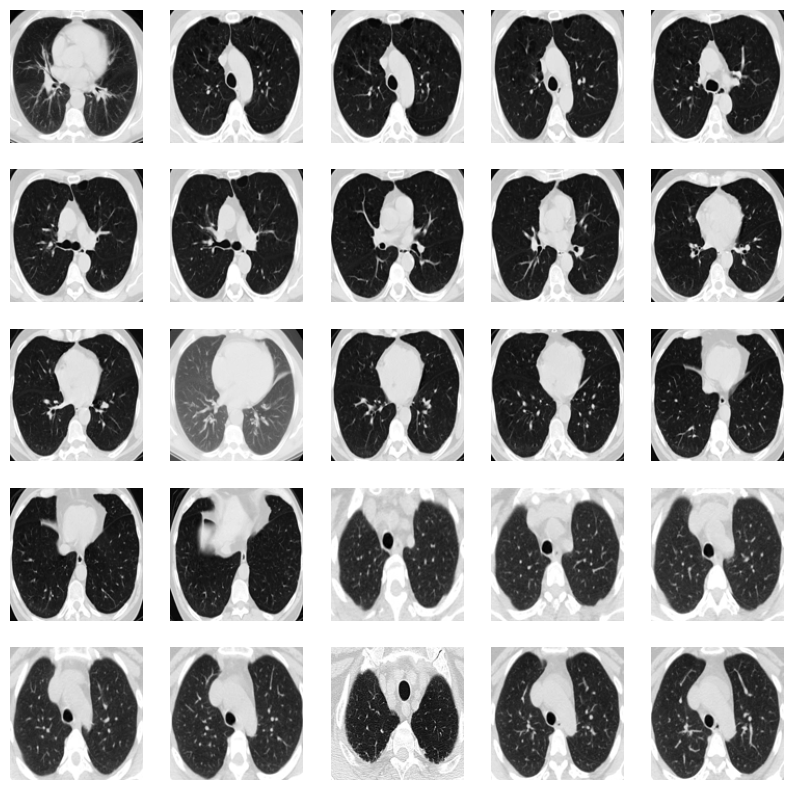

In [15]:
# Let's say you have a list of images stored in a variable called 'images'

# Set the number of rows and columns for the subplots
rows = 5
cols = 5

# Create a figure and axes for the subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# Flatten the axes array to make it easier to iterate over
axes = axes.ravel()

# Iterate over the images and plot each one
for i, img in enumerate(images):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    
plt.show()

In [16]:
# Split the data into initial training set, pool, and test set
X_initial, X_pool, y_initial, y_pool = train_test_split(X_train, y_train, test_size=0.5)

In [17]:
print(len(X_train))
# print("n_initial:", n_initial)
# print("initial_idx:", len(initial_idx))
print("X_initial:", len(X_initial), "|", X_initial.shape)
print("y_initial:", len(y_initial), "|", y_initial.shape)
print("X_pool:", len(X_pool), "|", X_pool.shape)
print("y_pool:", len(y_pool), "|", y_pool.shape)

1523
X_initial: 761 | (761, 128, 128, 1)
y_initial: 761 | (761,)
X_pool: 762 | (762, 128, 128, 1)
y_pool: 762 | (762,)


In [18]:
learner = ActiveLearner(
    estimator=classifier,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

24/24 [==============================] - 11s 373ms/step - loss: 0.7137 - accuracy: 0.5099


24/24 [==============================] - 2s 79ms/step
[604]


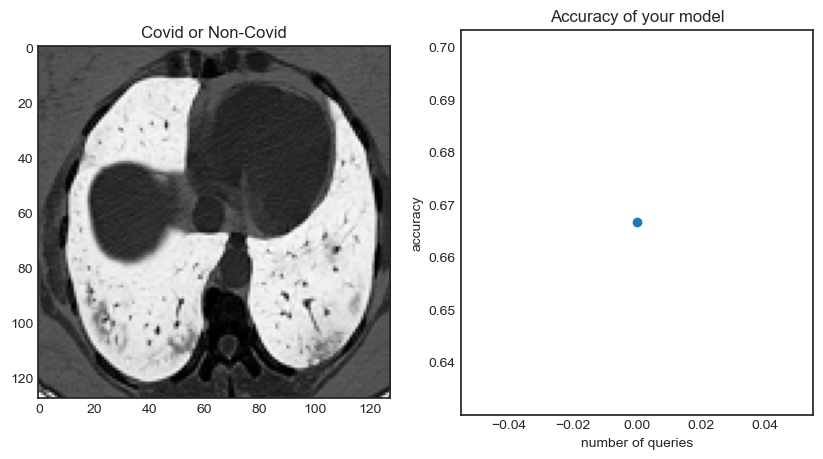

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
1
24/24 [==============================] - 2s 76ms/step
[583]


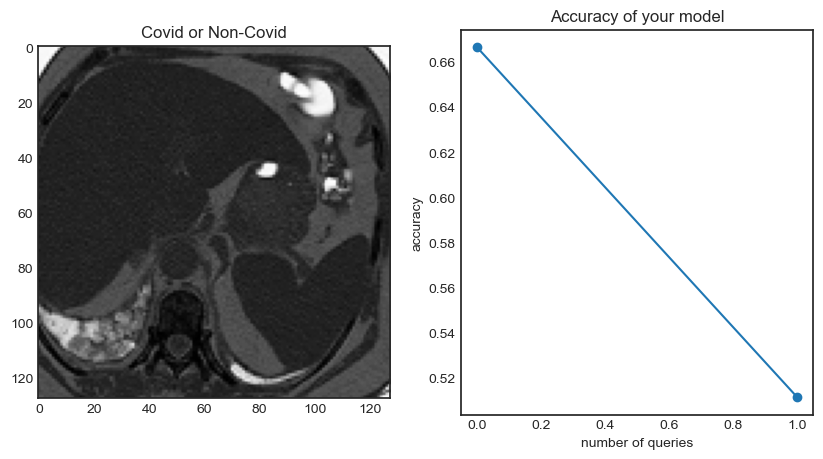

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
1
24/24 [==============================] - 2s 71ms/step
[631]


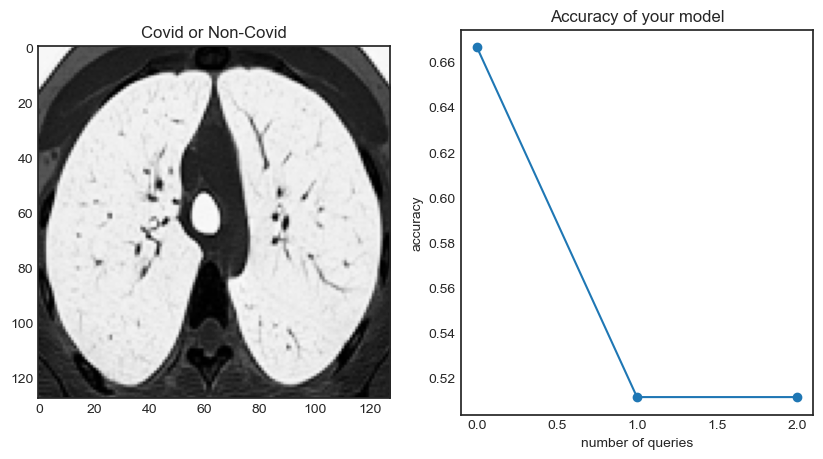

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
0
24/24 [==============================] - 2s 73ms/step
[544]


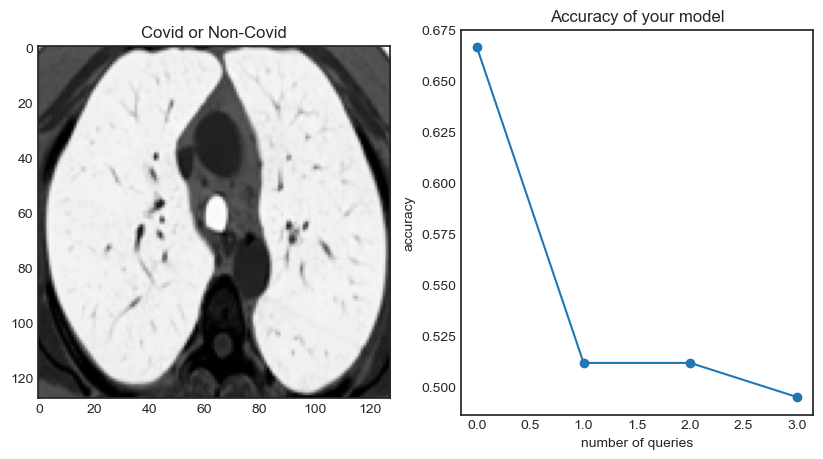

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
0
24/24 [==============================] - 2s 72ms/step
[558]


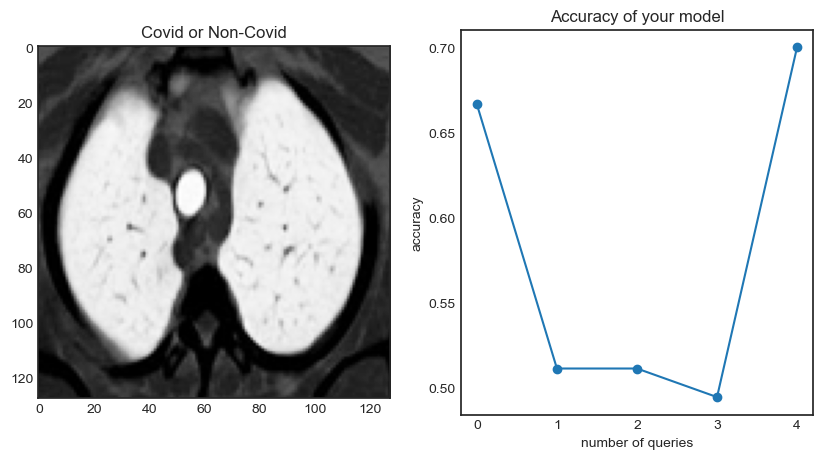

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
0
24/24 [==============================] - 2s 74ms/step
[649]


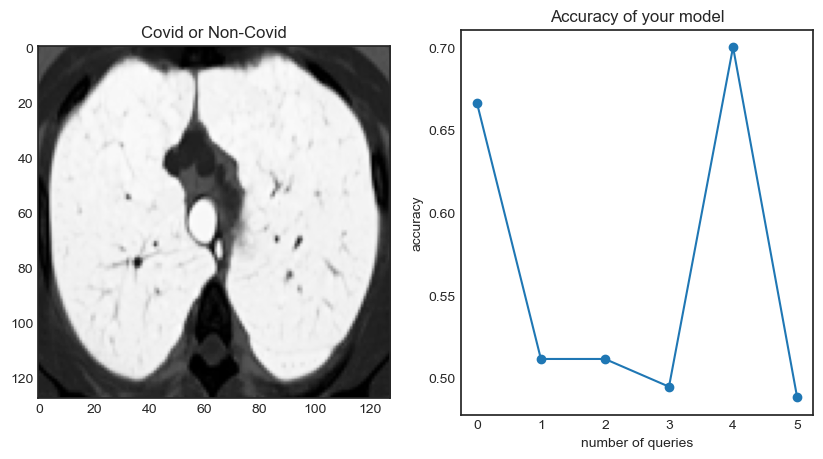

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
0
24/24 [==============================] - 2s 72ms/step
[436]


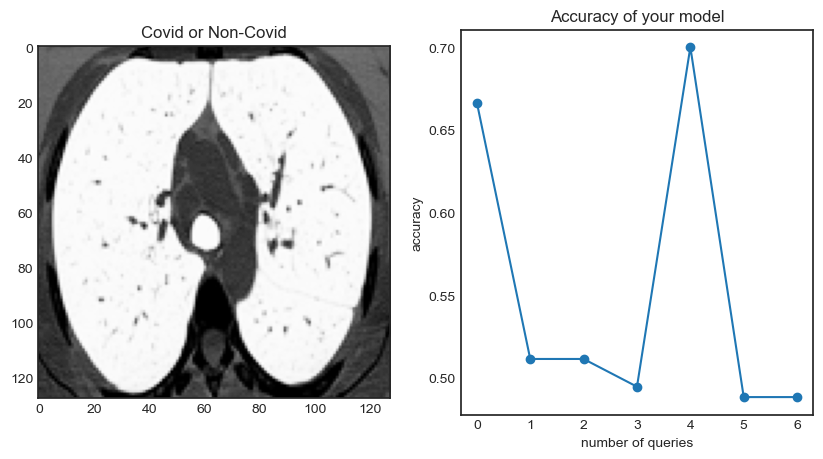

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
1
24/24 [==============================] - 2s 71ms/step
[358]


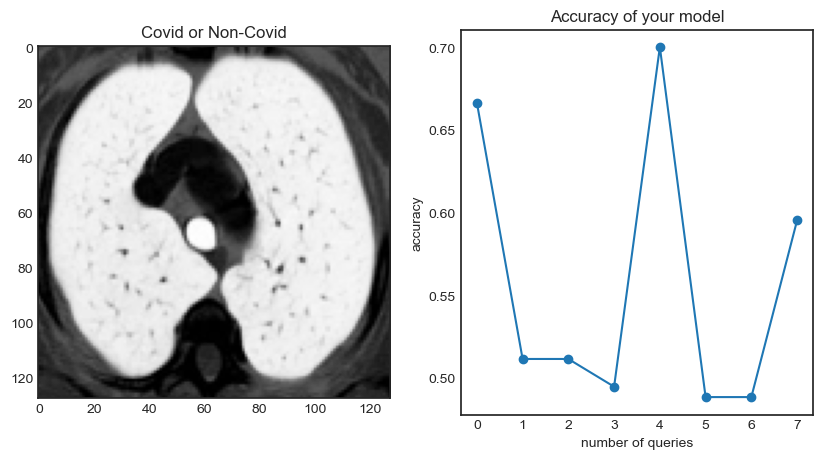

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
1
24/24 [==============================] - 2s 72ms/step
[528]


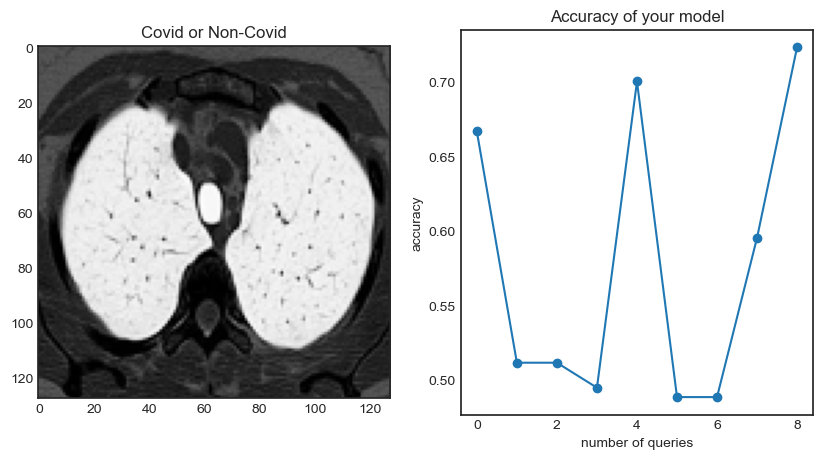

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
1
24/24 [==============================] - 2s 74ms/step
[458]


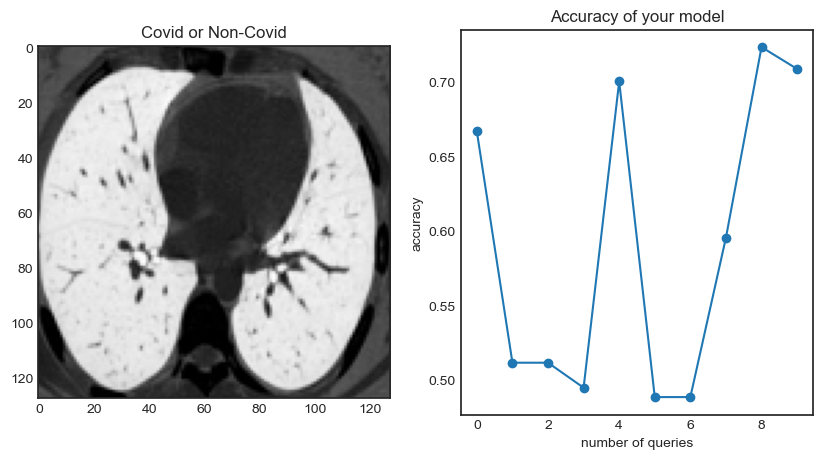

Is this a covid or non-covid image? (1 for covid, 0 for non-covid)
1
15/15 [==============================] - 1s 75ms/step - loss: 0.6035 - accuracy: 0.6541


In [21]:
# empty list accuracy_scores that will be used to store the accuracy 
# of the model at each iteration of the active learning loop.
accuracy_scores = [learner.score(X_test, y_test)]

n_queries = 10

# will run for n_queries number of iterations. 
for i in range(n_queries):
    #display.clear_output(wait=True)
    # selects an instance from the pool (X_pool) for which the model is most uncertain about.
    query_idx, query_inst = learner.query(X_pool)
    print(query_idx)
    #print(query_inst.shape)
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        # create two subplots side by side in the same figure, the first subplot is used to display the 
        # image of the selected instance and the second subplot is used to display the accuracy of the model 
        # over the number of iterations.
        plt.subplot(1, 2, 1)
        plt.title('Covid or Non-Covid')
        plt.imshow(query_inst.reshape(128, 128))
        plt.subplot(1, 2, 2)
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        # used to display the current figure on the screen
        display(plt.gcf())
        plt.close('all')

    print("Is this a covid or non-covid image? (1 for covid, 0 for non-covid)")
    y_new = np.array([int(input())], dtype=int)
    #print(y_new.shape)
    #print(query_inst.shape)
    learner.teach(query_inst, y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

In [26]:
test_score = classifier.score(X_test, y_test)
print('Test score:', test_score)

15/15 [==============================] - 1s 87ms/step - loss: 0.6035 - accuracy: 0.6541
Test score: 0.6540880799293518


15/15 [==============================] - 1s 82ms/step


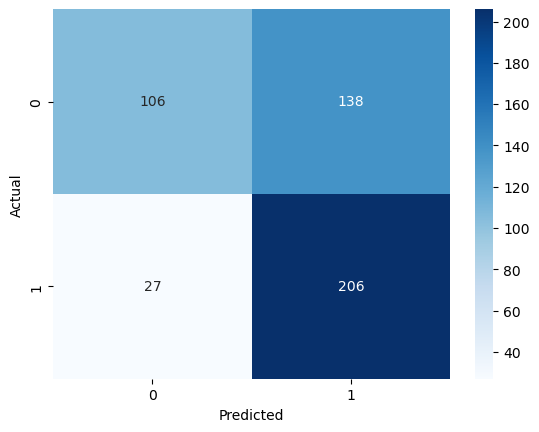

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = classifier.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score

# Predict the labels for the test dataset
y_pred = classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

15/15 [==============================] - 1s 82ms/step
Accuracy: 65.41%


In [101]:
import numpy as np
from PIL import Image

def predict_image(classifier, image_path):
    # Load the image and resize it
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((128, 128))
    img = np.array(img)
    img = img / 255
    img = np.expand_dims(img, 2)
    img = np.expand_dims(img, 0)

    # Make a prediction using the classifier
    prediction = classifier.predict(img)
    if prediction[0][0] >= 0.5:
        return 'Covid'
    else:
        return 'Non-Covid'

In [102]:
imgs_array = []

for i in range(1, 51):
    image_path = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\Unlabeled\\' + f'Non-Covid ({i}).png' 
    print(predict_image(classifier, image_path))

1/1 [==============================] - 0s 50ms/step
Covid
1/1 [==============================] - 0s 59ms/step
Covid
1/1 [==============================] - 0s 53ms/step
Non-Covid
1/1 [==============================] - 0s 76ms/step
Non-Covid
1/1 [==============================] - 0s 63ms/step
Non-Covid
1/1 [==============================] - 0s 48ms/step
Non-Covid
1/1 [==============================] - 0s 48ms/step
Non-Covid
1/1 [==============================] - 0s 56ms/step
Non-Covid
1/1 [==============================] - 0s 66ms/step
Non-Covid
1/1 [==============================] - 0s 52ms/step
Non-Covid
1/1 [==============================] - 0s 44ms/step
Non-Covid
1/1 [==============================] - 0s 57ms/step
Non-Covid
1/1 [==============================] - 0s 46ms/step
Covid
1/1 [==============================] - 0s 49ms/step
Non-Covid
1/1 [==============================] - 0s 52ms/step
Covid
1/1 [==============================] - 0s 38ms/step
Covid
1/1 [=======================

In [91]:
for i in range(1, 51):
    image_path = r'C:\Users\karip\OneDrive\PC\Centre\University\Classes\Digital Processing of Biosignals\Assignments\COVID 19 Detection using AL and CNN\Dataset\Unlabeled\\' + f'Covid ({i}).png' 
    print(predict_image(classifier, image_path))

1/1 [==============================] - 0s 49ms/step
Non-Covid
1/1 [==============================] - 0s 47ms/step
Covid
1/1 [==============================] - 0s 46ms/step
Covid
1/1 [==============================] - 0s 69ms/step
Covid
1/1 [==============================] - 0s 53ms/step
Covid
1/1 [==============================] - 0s 53ms/step
Covid
1/1 [==============================] - 0s 54ms/step
Covid
1/1 [==============================] - 0s 51ms/step
Covid
1/1 [==============================] - 0s 48ms/step
Covid
1/1 [==============================] - 0s 53ms/step
Covid
1/1 [==============================] - 0s 64ms/step
Covid
1/1 [==============================] - 0s 62ms/step
Non-Covid
1/1 [==============================] - 0s 49ms/step
Non-Covid
1/1 [==============================] - 0s 48ms/step
Non-Covid
1/1 [==============================] - 0s 52ms/step
Non-Covid
1/1 [==============================] - 0s 49ms/step
Non-Covid
1/1 [==============================] - 0s 49ms/s